<a href="https://colab.research.google.com/github/omrihaber/L2CWDN/blob/main/L2CWDN_quantization_and_binay_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to Cooperate in Decentralized Wireless Networks

https://ieeexplore.ieee.org/document/8645377


 ## extra links/resources:
  ### https://arxiv.org/pdf/1607.00133.pdf
  ### https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/5

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F

# import torchsnooper

# from livelossplot import PlotLosses
# liveplot = PlotLosses()

#use gpu if available
torch.set_default_tensor_type(torch.DoubleTensor)
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


# Constants and utility functions

## $10 = SN{R_{dB}} = 10{\log _{10}}SNR \Rightarrow$
## $\Rightarrow {\log _{10}}SNR = 1 \Rightarrow SNR = 10$

## we assume that the Gain Matrix is 1

In [ ]:
K = 2 #number of TX/RX Pairs
G = torch.ones((K,K)) # Gain Matrix
SNR = 10.0 #Signal to noise ratio
TRAINING_SIZE = 4000 #number of samples to generate for training set
EPOCHS = 1000 # number of times the DNN will go over the entire training set
BATCH_SIZE = 400 # number of samples the net will go over before each gradient update
NUM_OF_BATCHES = TRAINING_SIZE/BATCH_SIZE
EVAULUATION_SIZE = 10000 # number of samples generated to evaluate the model
HIDDEN_LAYERS = 4 
HIDDEN_LAYER_SIZE = 50
LR = 0.00003 # learning rate

QUANTIZATION = 8 # number of bits to quanatize the messages

SERIALIZATION_PREFIX = "./experminet_"


In [ ]:
def generate_path(sigma,v=1,K=K,SERIALIZATION_PREFIX=SERIALIZATION_PREFIX):
    path = SERIALIZATION_PREFIX
    path += "v" + str(v)+"_"
    path += "k" + str(K)+"_"
    path += "sigma_" + str(sigma)
    path += ".pth"
    return path

In [ ]:
send_to_device = lambda t,device=device : t.to(device)
send_nets_to_device = lambda nets,device=device: [send_to_device(net) for net in nets]

In [ ]:
repeat_constant = lambda constant,size=1 : torch.tensor([constant]).repeat(size).double()

## AWGN := adding zero mean normal distribution with SNR Variance

In [ ]:
generate_noise = lambda size,mean=0,SNR=SNR:torch.empty(size).normal_(mean=mean,std=SNR)

In [ ]:
#example
generate_noise((1,4))

tensor([[  4.4363, -14.7317,  -2.4254,  -3.9425]])

In [ ]:
# add_noise = lambda x,SNR=SNR,size=1:torch.add(x,torch.normal(0,SNR,size))
# add_noise = lambda x,SNR=SNR:torch.add(x,generate_noise(x.size(),SNR=SNR))

# @torchsnooper.snoop()
def add_noise(x,SNR=SNR):
    return torch.add(x,generate_noise(x.size(),SNR=SNR))

In [ ]:
#example
add_noise(torch.tensor((100,100,100,100)).double())

tensor([104.9576,  94.5872,  94.6660, 117.1210])

In [ ]:
def plot(x = np.linspace(-1,1,50) , func=lambda x:x):
    y = func(x)
    plt.plot(x, y)
    plt.show()

In [ ]:
def plot_array(x = np.linspace(-1,1,50) , y = np.linspace(-1,1,50)):
    plt.plot(x, y)
    plt.show()

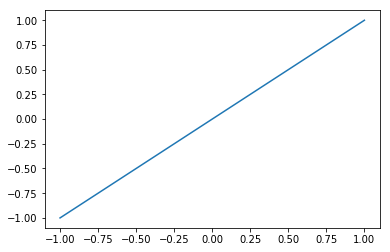

In [ ]:
plot_array()

## $sigmoid\left( {x,p} \right): = \frac{1}{{1 + {e^{ - px}}}}$

In [ ]:
def sigmoid(x,p=1):
    return 1.0 / (1.0 + torch.exp(-x*p))

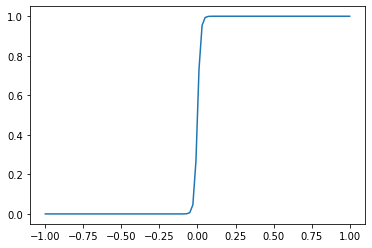

In [ ]:
sig = lambda x,p=1:1.0/(1.0+np.exp(-1*x*p))
plot_array(x=np.linspace(-1,1,100),y=sig(np.linspace(-1,1,100),p=100))

In [ ]:
print(sig(1))
print(sig(2))
print(sig(3))

0.7310585786300049
0.8807970779778823
0.9525741268224334


In [ ]:
x = np.array([1,2,3])
x2 = x+x
print(x,sig(x))
print(x2,sig(x2))
print(x,x*x)

[1 2 3] [0.73105858 0.88079708 0.95257413]
[2 4 6] [0.88079708 0.98201379 0.99752738]
[1 2 3] [1 4 9]


In [ ]:
sigmoid(torch.ones(1))

tensor([0.7311])

## the slope of the sigmoid is proportional to the epoch  in the training stage

In [ ]:
#generate a function that after being invoked train_size(after 1 epoch) times increases p by 1
def generate_proportional_sigmoid(train_size):
    p = 1
    calls = 1
    def proportional_sigmoid(x):
        nonlocal p
        nonlocal calls
        ret = sigmoid(x,p=p)
        if calls == train_size:
            calls = 0
            p += 1
        calls += 1
        return ret
    return proportional_sigmoid

## $\Delta$ contains i.i.d. Chi-square random variables
## degress of freedom = ?, chosen 2 arbitrarily

In [ ]:
generate_delta = lambda k=K,df=2: send_to_device(torch.from_numpy(np.random.chisquare(df,(k,k))).double())

# Hadamard Product / Element wise product

In [ ]:
# hadamard = lambda a,b:np.mat(np.array(a)*np.array(b))
hadamard = lambda a,b:torch.mul(a,b)

## $\bar \Sigma : = \sqrt {1 - {\Sigma ^2}} \,\,(7)$

In [ ]:
# sigma_line = lambda sigma:np.sqrt(1-(sigma**2))
sigma_line = lambda sigma:torch.sqrt(1-torch.pow(sigma,2))

## $\hat G: = \bar \Sigma  \odot G + \Sigma  \odot \Delta \,\,(7)$

In [ ]:
# g_hat = lambda sigma,G=G:hadamard(sigma_line(sigma),G)+hadamard(sigma,generate_delta())
g_hat = lambda sigma,G=G:torch.add(hadamard(sigma_line(sigma),G),hadamard(sigma,generate_delta())).double()

# Data Generation

In [ ]:
def generate_data(sigmas,num_of_batches,batch_size=BATCH_SIZE,G=G,K=K):
#     return np.array([[[g_hat(sigma,G=G) for _ in range(int(batch_size))] for sigma in sigmas] for _ in range(int(num_of_batches))])
    return [[torch.stack([g_hat(sigma,G=G) for _ in range(int(batch_size))]).view(-1,K**2) for sigma in sigmas] for _ in range(int(num_of_batches))]

In [ ]:
generate_train_data = lambda sigmas,num_of_batches=TRAINING_SIZE/BATCH_SIZE,batch_size=BATCH_SIZE,G=G,K=K: generate_data(sigmas,num_of_batches,batch_size,G,K)

In [ ]:
# generate_evaluation_data = lambda sigmas,num_of_batches=1,EVAULUATION_SIZE=EVAULUATION_SIZE,G=G,K=K: generate_data(sigmas,num_of_batches,EVAULUATION_SIZE,G,K)[0]
generate_evaluation_data = lambda sigmas,EVAULUATION_SIZE=EVAULUATION_SIZE,G=G,K=K: [torch.stack([g_hat(sigma,G=G) for _ in range(EVAULUATION_SIZE)]).view(-1,K**2) for sigma in sigmas]

In [ ]:
# generate_evaluation_data([torch.ones((K,K)),torch.ones((K,K))])

In [ ]:
x= torch.ones((K,K))
x.type()

'torch.cuda.DoubleTensor'

In [ ]:
generate_data([torch.ones((K,K))],2,2)

[[tensor([[2.2722, 5.2360, 3.9678, 0.6250],
          [1.7615, 1.0216, 1.1441, 1.4055]])],
 [tensor([[1.1250, 4.2486, 0.5242, 1.8407],
          [4.5644, 1.5094, 1.5669, 1.0538]])]]

# Model Generation

In [ ]:
class MessageMaker(nn.Module):
    def __init__(self,h_layers, h_size,k,training_size):
        super(MessageMaker, self).__init__()
        
        self.h_layers=h_layers
        self.proportional_sigmoid = generate_proportional_sigmoid(training_size)
        
        self.messageMaker = nn.ModuleList()
        self.messageMaker.append(nn.Linear(k**2,h_size)) #input layer
        for k in range(h_layers):        #hidden layers
            self.messageMaker.append(nn.Linear(h_size, h_size))
        self.messageMaker.append(nn.Linear(h_size,1)) #output layer | s_i,j
    
    def forward(self, x):
        #conditional step_function
        step_function = lambda x: 1*(x>0)
        if self.training:
            step_function = self.proportional_sigmoid
        #pass the input through the network
        for i in range(self.h_layers+1): #hidden layers + input layer
            x = F.relu(self.messageMaker[i](x)) #relu is used as the activation function except for the output layer
        output = step_function(self.messageMaker[-1](x))
        return output

## making the following assumption
##  "We study link scheduling which means that each
## TX may decide between transmitting with a fixed maximum
## power level P or staying idle for one channel realization"
## Team Deep Neural Networks for Interference Channels


In [ ]:
class DecisionMaker(nn.Module):
    def __init__(self,h_layers, h_size,k):
        super(DecisionMaker, self).__init__()
        
        self.h_layers=h_layers
        
        self.decisionMaker = nn.ModuleList()
        self.decisionMaker.append(nn.Linear(k**2+k,h_size)) #input layer -> estimation of gain matrix + k messages
        for k in range(h_layers):        #hidden layers
            self.decisionMaker.append(nn.Linear(h_size, h_size))
        self.decisionMaker.append(nn.Linear(h_size,1)) #output layer | s_i,j
    
    def forward(self, x):
        #pass the input through the network
        for i in range(self.h_layers+2): #hidden layers + input layer + output layer
            x = F.relu(self.decisionMaker[i](x)) #relu is used as the activation function except for the output layer
        output = x
        return output

In [ ]:
def generate_models(h_layers=HIDDEN_LAYERS, h_size=HIDDEN_LAYER_SIZE,k=K,training_size=TRAINING_SIZE):
    decisionMakers = [send_to_device(DecisionMaker(h_layers=h_layers,h_size=h_size,k=k)) for _ in range(k)]
    messageMakers = [send_to_device(MessageMaker(h_layers=h_layers,h_size=h_size,k=k,training_size=training_size)) for _ in range(k)]
    return decisionMakers,messageMakers

In [ ]:
# messageMakers[0]

# $R\left( {{p_1},...,{p_k}} \right) = \mathop \sum \limits_{k = 1}^K \lg \left( {1 + \frac{{{g_{k,k}}{p_k}}}{{N + \mathop \sum \limits_{k \ne j} {g_{k,j}}{p_j}}}} \right) = \mathop \sum \limits_{k = 1}^K \lg \left( {1 + \frac{{{g_{k,k}}{p_k}}}{{N + \mathop \sum \limits_j {g_{k,j}}{p_j} - {g_{k,k}}{p_k}}}} \right) = \lg \mathop \Pi \limits_{k = 1}^K \left( {1 + \frac{{{g_{k,k}}{p_k}}}{{N + \mathop \sum \limits_j {g_{k,j}}{p_j} - {g_{k,k}}{p_k}}}} \right) $

In [ ]:
def R(powers,K=K,G=G,noise_power=0):
    # replace with DI
    batch_size = len(powers)
    size = (batch_size,1)
    N = repeat_constant(noise_power,size)
    ret = torch.ones(size)
    for k in range(K):
        gkk = repeat_constant(G[k][k],size)
        pk = torch.narrow(powers,1,k,1)
        gkk_pk = hadamard(gkk , pk)
        sum_j_not_k = torch.zeros(size)
        for j in range(K):
            gkj =  repeat_constant(G[k][j],size)
            pj = torch.narrow(powers,1,j,1)
            gkj_pj = hadamard(gkj , pj)
            sum_j_not_k = torch.add(sum_j_not_k,gkj_pj)
        sum_j_not_k -= pk
        pi_term = torch.add(torch.ones(size),(gkk_pk/(N+sum_j_not_k)))
        ret = hadamard(pi_term,ret)
    ret = torch.log2(ret)
    return ret

## loss is an inverse function to R: minimizing this function will maximize R

In [ ]:
def loss_function(output,G=G,K=K,noise_power=0):
    size = (len(output),1)
    one = repeat_constant(1,size)
    rate = R(output,K=K,noise_power=noise_power)
#     print("max rate:")
#     print(torch.max(rate))
    return torch.mean(rate),torch.mean(one/(rate+one))

# Model Training

In [ ]:
change_models_mode_to_eval = lambda models: [model.eval() for model in models]
change_models_mode_to_train = lambda models: [model.train() for model in models]

In [ ]:
def zero_grad_array(arr):
    for net in arr:
        net.zero_grad()
def optimizer_step_array(arr):
    for optimizer in arr:
        optimizer.step()

In [ ]:
generate_tensor_from_output_array = lambda messages_array:torch.cat(messages_array,1).double()
generate_power_tensor_from_powers_array = lambda powers_array:torch.cat(powers_array,1).double()

In [ ]:
def generate_messages_tensor_for_user_k(messages,messages_with_noise,k,K=K):
        transfer_without_noise = torch.narrow(messages, 1, k,1)     
        transfer_with_noise_prefix = torch.narrow(messages_with_noise, 1, k,k) if k>0 else None
        transfer_with_noise_suffix =  torch.narrow(messages_with_noise, 1, k+1,K-k-1) if k<K else None
        
        if transfer_with_noise_prefix is not None and transfer_with_noise_suffix is not None:
            return torch.cat([transfer_with_noise_prefix,transfer_without_noise,transfer_with_noise_suffix],1)
        elif transfer_with_noise_prefix is not None:
            return torch.cat([transfer_with_noise_prefix,transfer_without_noise],1)
        else:
            return torch.cat([transfer_without_noise,transfer_with_noise_suffix],1)

def generate_messages_tensor_for_all_users(messages,messages_with_noise,K=K):
    return [generate_messages_tensor_for_user_k(messages,messages_with_noise,k,K=K) for k in range(K)]
    

In [ ]:
def generate_decision_maker_input(batch,messages,messages_with_noise,K=K):
    messages_tensor = generate_messages_tensor_for_all_users(messages,messages_with_noise,K=K)
    return [torch.cat([batch[k],messages_tensor[k]],1) for k in range(K)]

## assumption K=2

## serialize_model

In [ ]:
models_to_state_dicts = lambda models:[model.state_dict() for model in models]
optimizers_to_state_dicts = lambda optimizers:[optimizer.state_dict() for optimizer in optimizers]

In [ ]:
def seralize_model(messageMakers,decisionMakers,messageMakersOptimizers,decisionMakersOptimizers,loss,rate,epoch=EPOCHS,path="./model.pt"):
    messageMakers_state_dicts = models_to_state_dicts(messageMakers)
    decisionMakers_state_dicts = models_to_state_dicts(decisionMakers)
    messageMakersOptimizers_state_dicts = optimizers_to_state_dicts(messageMakersOptimizers)
    decisionMakersOptimizers_state_dicts = optimizers_to_state_dicts(decisionMakersOptimizers)
    torch.save({
            'messageMakers_state_dicts': messageMakers_state_dicts,
            'decisionMakers_state_dicts': decisionMakers_state_dicts,
            'messageMakersOptimizers_state_dicts': messageMakersOptimizers_state_dicts,
            'decisionMakersOptimizers_state_dicts': decisionMakersOptimizers_state_dicts,
            'loss': loss,
            'epoch': epoch,
            'rate':rate
            }, path)

## Make sure to call input = input.to(device) on any input tensors that you feed to the model in order to make sure that its on the GPU

In [ ]:
def deseralize_model(path="./model.pt",h_layers=HIDDEN_LAYERS, h_size=HIDDEN_LAYER_SIZE,k=K,training_size=TRAINING_SIZE,lr=LR):
    decisionMakers , messageMakers = generate_models(h_layers=h_layers, h_size=h_size,k=k,training_size=training_size)
    decisionMakersOptimizers = [torch.optim.Adam(dm.parameters(),lr=lr) for dm in decisionMakers]
    messageMakersOptimizers = [torch.optim.Adam(mm.parameters(),lr=lr) for mm in messageMakers]
    
    checkpoint = torch.load(path)
    #load epoch loss and rate
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    rate = checkpoint['rate']
    #load models and optimizers
    for i in range(k):
        decisionMakers[i].load_state_dict(checkpoint['decisionMakers_state_dicts'][i])
        messageMakers[i].load_state_dict(checkpoint['messageMakers_state_dicts'][i])
        decisionMakersOptimizers[i].load_state_dict(checkpoint['decisionMakersOptimizers_state_dicts'][i])
        messageMakersOptimizers[i].load_state_dict(checkpoint['messageMakersOptimizers_state_dicts'][i])
    #change model mode to evaluation
    change_models_mode_to_eval(decisionMakers)
    change_models_mode_to_eval(messageMakers)
    #send models 2 GPU if available
    send_nets_to_device(decisionMakers)
    send_nets_to_device(messageMakers)
    return decisionMakers,messageMakers,decisionMakersOptimizers,messageMakersOptimizers,epoch,loss,rate
    

In [ ]:
#returns [[sigma,sigma;sigma,sigma],[0,0;0,0,]]
def generate_mat_from_sigma_v1(sigma):
    return [repeat_constant(constant=sigma,size=(2,2)),repeat_constant(constant=0,size=(2,2))]
#returns [[sigma,0;sigma,0],[0,sigma;0,sigma,]]
def generate_mat_from_sigma_v2(sigma):
    return [torch.tensor([[sigma,0],[sigma,0]]),torch.tensor([[0,sigma],[0,sigma]])]

In [ ]:
def train_models(sigmas,training_size = TRAINING_SIZE,epochs=EPOCHS,lr=LR,G=G,K=K,noise_power=SNR,HIDDEN_LAYERS=HIDDEN_LAYERS,HIDDEN_LAYER_SIZE=HIDDEN_LAYER_SIZE,seralization_path="./model.pt"):
    decisionMakers , messageMakers = generate_models(h_layers=HIDDEN_LAYERS, h_size=HIDDEN_LAYER_SIZE,k=K,training_size=training_size)
    decisionMakersOptimizers = [torch.optim.Adam(dm.parameters(),lr=lr) for dm in decisionMakers]
    messageMakersOptimizers = [torch.optim.Adam(mm.parameters(),lr=lr) for mm in messageMakers]
    change_models_mode_to_train(decisionMakers)
    change_models_mode_to_train(messageMakers)
    
    #todo: add DI for batch_size and num_of_batches
    training_data = generate_train_data(sigmas,G=G)
    
    
    K = len(messageMakers)
    
    for epoch in range(epochs):
        for batch in training_data:
            zero_grad_array(decisionMakers)
            zero_grad_array(messageMakers)
            
            #[[o_11,o_12,...o_1BATCH_SIZE],...,[o_K1,...,o_KBATCH_SIZE]]
            message_model_output_array = [messageMakers[k](batch[k]) for k in range(K)]
            #[[o_11,o_21,...o_K1],...[o_1BATCH_SIZE,...,o_KBATCH_SIZE]]
            messages = generate_tensor_from_output_array(message_model_output_array)
            
            messages_with_noise = add_noise(messages)
            
            dm_input = generate_decision_maker_input(batch,messages,messages_with_noise,K=K)
        
            #same process with the model output array
            powers_array = [decisionMakers[k](dm_input[k]) for k in range(K)]
            powers = generate_power_tensor_from_powers_array(powers_array)
            # Calculate loss / objective function
            avg_rate,loss = loss_function(powers,G=G,noise_power=noise_power)
            liveplot.update({'rate': avg_rate.item(),'loss':loss.item()})
            liveplot.draw()
#             loss.requires_grad = True
            # Calculate gradients
            loss.backward()
            #update weights
            optimizer_step_array(decisionMakersOptimizers)
            optimizer_step_array(messageMakersOptimizers)
            #plot loss
#             print("epoch",epoch ,"loss",loss)
#             print(loss)
#             vis.line(Y=loss.detach().numpy(), opts=dict(showlegend=True))
    return decisionMakers,messageMakers,decisionMakersOptimizers,messageMakersOptimizers
    

In [ ]:
def evaluate_models(sigmas,decisionMakers,messageMakers,EVAULUATION_SIZE=EVAULUATION_SIZE,G=G,noise_power=SNR):
    change_models_mode_to_eval(decisionMakers)
    change_models_mode_to_eval(messageMakers)
    eval_data = generate_evaluation_data(sigmas,G=G,EVAULUATION_SIZE=EVAULUATION_SIZE)
    #[[o_11,o_12,...o_1BATCH_SIZE],...,[o_K1,...,o_KBATCH_SIZE]]
    message_model_output_array = [messageMakers[k](eval_data[k]) for k in range(K)]
    #[[o_11,o_21,...o_K1],...[o_1BATCH_SIZE,...,o_KBATCH_SIZE]]
    messages = generate_tensor_from_output_array(message_model_output_array)
    messages_with_noise = add_noise(messages)

    dm_input = generate_decision_maker_input(eval_data,messages,messages_with_noise,K=K)

    #same process with the model output array
    powers_array = [decisionMakers[k](dm_input[k]) for k in range(K)]
    powers = generate_power_tensor_from_powers_array(powers_array)
    # Calculate loss / objective function
    avg_rate,loss = loss_function(powers,G=G,noise_power=noise_power)
    return loss,avg_rate
    
    

In [ ]:
def run_and_save_experiment(sigmas,training_size = TRAINING_SIZE,EVAULUATION_SIZE=EVAULUATION_SIZE,epochs=EPOCHS,lr=LR,G=G,K=K,noise_power=SNR,HIDDEN_LAYERS=HIDDEN_LAYERS,HIDDEN_LAYER_SIZE=HIDDEN_LAYER_SIZE,seralization_path="./model.pt"):
    decisionMakers,messageMakers,decisionMakersOptimizers,messageMakersOptimizers = train_models(epochs=epochs,G=G,sigmas=sigmas,noise_power=noise_power,seralization_path=seralization_path)
    loss,rate = evaluate_models(sigmas,decisionMakers,messageMakers,EVAULUATION_SIZE=EVAULUATION_SIZE)
    seralize_model(decisionMakers=decisionMakers,decisionMakersOptimizers=decisionMakersOptimizers,messageMakers=messageMakers,messageMakersOptimizers=messageMakersOptimizers,rate=rate,loss=loss,epoch=epochs,path=seralization_path)

In [ ]:
def run_and_save_experiments(TRAINING_SIZE = TRAINING_SIZE,EPOCHS=EPOCHS,G=G,LR=LR,noise_power=SNR,HIDDEN_LAYERS=HIDDEN_LAYERS,HIDDEN_LAYER_SIZE=HIDDEN_LAYER_SIZE):
    for k in [2]:
        #assuming k=2 will need to modify if k>3
        # 0,0.2,0.4,0.6,0.8,1
        for sigma in torch.linspace(0, 1, steps=6):
            sigmas_v1 = generate_mat_from_sigma_v1(sigma)
            sigmas_v2 = generate_mat_from_sigma_v2(sigma)
            
#             v1_serialization_string = "./experminet_v1_k_"+str(k)+"_"+str(sigma.item())+".pth"
            v1_serialization_string = generate_path(sigma.item(),v=1)
#             v2_serialization_string = "./experminet_v2_k_"+str(k)+"_"+str(sigma.item())+".pth"
            v2_serialization_string = generate_path(sigma.item(),v=2)
            
            print("training v1 with sigma="+str(sigma.item()))
            run_and_save_experiment(sigmas_v1,training_size = TRAINING_SIZE,epochs=EPOCHS,lr=LR,G=G,K=K,noise_power=SNR,HIDDEN_LAYERS=HIDDEN_LAYERS,HIDDEN_LAYER_SIZE=HIDDEN_LAYER_SIZE,seralization_path=v1_serialization_string)
            print("training v2 with sigma="+str(sigma.item()))
            run_and_save_experiment(sigmas_v2,training_size = TRAINING_SIZE,epochs=EPOCHS,lr=LR,G=G,K=K,noise_power=SNR,HIDDEN_LAYERS=HIDDEN_LAYERS,HIDDEN_LAYER_SIZE=HIDDEN_LAYER_SIZE,seralization_path=v2_serialization_string)
            
            
    

## assumption Noise Power = $\sigma^2=SNR=10$

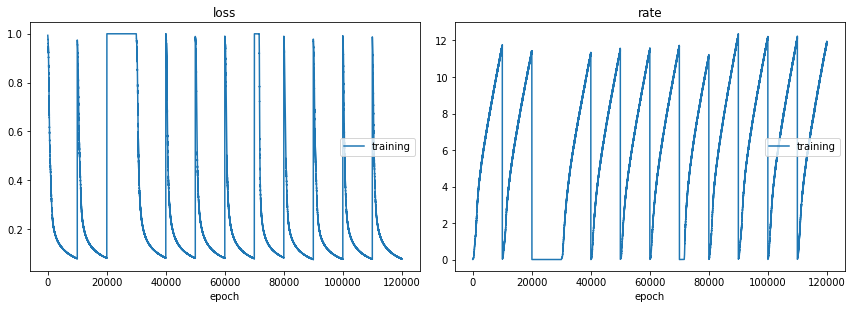

Wall time: 12h 30min 7s


In [ ]:
%time run_and_save_experiments()

# Evaluations

## model.eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
## torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).

In [ ]:
losses_v1 = []
rates_v1 = []
losses_v2 = []
rates_v2 = []

for sigma in torch.linspace(0, 1, steps=6):
    sigmas_v1 = generate_mat_from_sigma_v1(sigma)
    sigmas_v2 = generate_mat_from_sigma_v2(sigma)

    v1_serialization_string = "./experminet_v1_k_2_"+str(sigma.item())+".pth"
    v2_serialization_string = "./experminet_v2_k_2_"+str(sigma.item())+".pth"
    decisionMakers,messageMakers,decisionMakersOptimizers,messageMakersOptimizers,epoch,loss,rate = deseralize_model(path=v1_serialization_string)
    print(v1_serialization_string+" loss:"+str(loss.item()))
    print(v1_serialization_string+" rate:"+str(rate.item()))
    losses_v1.append(loss.item())
    rates_v1.append(rate.item())
    decisionMakers,messageMakers,decisionMakersOptimizers,messageMakersOptimizers,epoch,loss,rate = deseralize_model(path=v2_serialization_string)
    print(v2_serialization_string+" loss:"+str(loss.item()))
    print(v2_serialization_string+" rate:"+str(rate.item()))
    losses_v2.append(loss.item())
    rates_v2.append(rate.item())

./experminet_v1_k_2_0.0.pth loss:0.07875288496047629
./experminet_v1_k_2_0.0.pth rate:11.725033747892057
./experminet_v2_k_2_0.0.pth loss:0.08085303255633881
./experminet_v2_k_2_0.0.pth rate:11.397606430308697
./experminet_v1_k_2_0.2.pth loss:0.9999999747378752
./experminet_v1_k_2_0.2.pth rate:0.0
./experminet_v2_k_2_0.2.pth loss:0.0815081257129481
./experminet_v2_k_2_0.2.pth rate:11.297346028809368
./experminet_v1_k_2_0.4.pth loss:0.08025353525098858
./experminet_v1_k_2_0.4.pth rate:11.489974660416301
./experminet_v2_k_2_0.4.pth loss:0.0801186372889213
./experminet_v2_k_2_0.4.pth rate:11.503254880255994
./experminet_v1_k_2_0.6000000000000001.pth loss:0.07894687078817622
./experminet_v1_k_2_0.6000000000000001.pth rate:11.690088986848618
./experminet_v2_k_2_0.6000000000000001.pth loss:0.08233929588960226
./experminet_v2_k_2_0.6000000000000001.pth rate:11.173966913138308
./experminet_v1_k_2_0.8.pth loss:0.07515729474544704
./experminet_v1_k_2_0.8.pth rate:12.326495335071169
./experminet_

In [ ]:
rates_v1

[11.725033747892057,
 0.0,
 11.489974660416301,
 11.690088986848618,
 12.326495335071169,
 12.126690531328247]

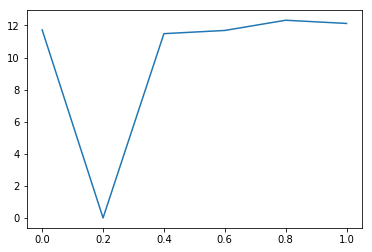

In [ ]:
plot_array(x=np.linspace(0, 1, 6),y=rates_v1)

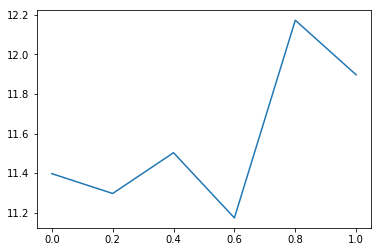

In [ ]:
plot_array(x=np.linspace(0, 1, 6),y=rates_v2)

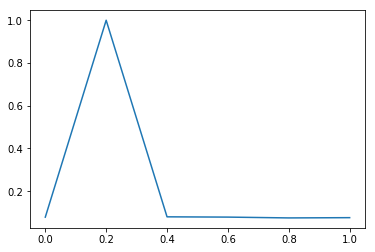

In [ ]:
plot_array(x=np.linspace(0, 1, 6),y=losses_v1)

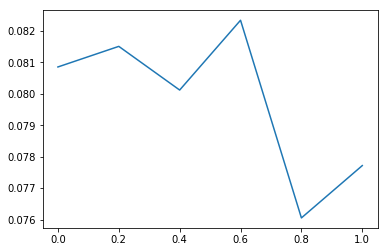

In [ ]:
plot_array(x=np.linspace(0, 1, 6),y=losses_v2)